In [24]:
import os
STEPS = "./steps"
if not os.path.isdir(STEPS):
    os.mkdir(STEPS)

### Build and Run Dataset Downloader

In [25]:
!cd sub/paralells ; cargo build --release ; ./target/release/paralells --inputfolder "input (new data)" --outputfile result.csv

 --> src/main.rs:2:5
  |
2 | use csv::StringRecord;
  |     ^^^^^^^^^^^^^^^^^
  |
  = note: `#[warn(unused_imports)]` on by default

 --> src/main.rs:3:5
  |
3 | use http::Request;
  |     ^^^^^^^^^^^^^

  --> src/main.rs:9:16
   |
 9 |     fs::{self, DirEntry, File, FileType},
   |                ^^^^^^^^        ^^^^^^^^
10 |     io::{Cursor, Read, Write},
11 |     path::{self, Path, PathBuf},
   |            ^^^^

   --> src/main.rs:129:37
    |
129 |             InputFile::Real { path, baseid } => Some(vec![path.clone()]),
    |                                     ^^^^^^ help: try ignoring the field: `baseid: _`
    |
    = note: `#[warn(unused_variables)]` on by default

    Finished `release` profile [optimized] target(s) in 0.21s


In [ ]:
%run createDerivation.py

import cv2
import os
import numpy as np
import pandas as pd
from ultralytics import YOLO

INPUT_FOLDER = "./sub/paralells/steps/convertedtemp/" 

# 2. Set the path where the processed images will be saved.
OUTPUT_FOLDER = "processed_images" 

# 3. Define the target object classes the script should look for.
TARGET_CLASSES = ['banana', 'apple', 'avocado'] 

# 4. Define the final output size for the images.
FINAL_SIZE = (720, 720) 

# 5. Choose the model. 'yolov8n.pt' is small and fast, perfect for this.
MODEL_NAME = 'yolo11x-seg.pt' 

all_df = pd.read_csv("./sub/paralells/result.csv")

def keep_all(path): return True

# Build a YOLO-based preprocessing + filtering pipeline using create_dataset_variation

# Choose base dataset to (re)process
target_df = all_df

# Ensure required globals exist
assert 'MODEL_NAME' in globals(), "MODEL_NAME not defined (from earlier YOLO cell)."
assert 'FINAL_SIZE' in globals(), "FINAL_SIZE not defined (from earlier YOLO cell)."
assert 'TARGET_CLASSES' in globals(), "TARGET_CLASSES not defined (from earlier YOLO cell)."
assert 'create_dataset_variation' in globals(), "create_dataset_variation not available."

print(f"Loading YOLO model: {MODEL_NAME} ...")
try:
    _yolo_model = YOLO(MODEL_NAME)
except Exception as e:
    raise RuntimeError(f"Failed to load YOLO model '{MODEL_NAME}': {e}")

_target_classes = set(TARGET_CLASSES)

def _best_square_crop_from_results(image, results, names):
    img_h, img_w = image.shape[:2]
    best_detection = None
    highest_conf = -1.0

    for result in results:
        if result.boxes is None:
            continue
        for box in result.boxes:
            class_id = int(box.cls[0])
            class_name = names.get(class_id, str(class_id))
            if class_name not in _target_classes:
                continue
            conf = float(box.conf[0])
            if conf > highest_conf:
                highest_conf = conf
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().tolist()
                best_detection = (x1, y1, x2, y2)

    if best_detection is None:
        return None

    x1, y1, x2, y2 = best_detection
    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)
    dist_to_top = cy
    dist_to_bottom = img_h - cy
    dist_to_left = cx
    dist_to_right = img_w - cx
    half_size = int(min(dist_to_top, dist_to_bottom, dist_to_left, dist_to_right))
    if half_size <= 0:
        return None
    return (
        max(0, cx - half_size),
        max(0, cy - half_size),
        min(img_w, cx + half_size),
        min(img_h, cy + half_size),
    )

print("PHASE 1: YOLO Detection and Crop Region Precomputation")
# Precompute crop regions for all valid images in base_df
print(f"Scanning {len(target_df)} images for target objects: {sorted(_target_classes)}")
_crop_index = {}
_skipped = 0
for i, row in target_df.iterrows():
    p = row["file_path"]
    if not isinstance(p, str) or not os.path.isfile(p):
        _skipped += 1
        continue
    img = cv2.imread(p)
    if img is None:
        _skipped += 1
        continue
    try:
        results = _yolo_model(img, verbose=False)
        crop_box = _best_square_crop_from_results(img, results, _yolo_model.names)
        if crop_box is not None:
            _crop_index[p] = crop_box
    except Exception:
        _skipped += 1

print(f"Found {len(_crop_index)} images with target detections. Skipped: {_skipped}")

def yolo_filter_fn(path: str) -> bool:
    return path in _crop_index

def yolo_crop_map_fn(path: str) -> bytes:
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not read image: {path}")
    x1, y1, x2, y2 = _crop_index.get(path, (0, 0, img.shape[1], img.shape[0]))
    cropped = img[y1:y2, x1:x2]
    if cropped.size == 0:
        cropped = img  # fallback to original if something went wrong
    resized = cv2.resize(cropped, FINAL_SIZE, interpolation=cv2.INTER_AREA)
    ok, buf = cv2.imencode(".png", resized)
    if not ok:
        raise RuntimeError("Failed to encode cropped image.")
    return buf.tobytes()

variation_tag = f"yolo_crop_{MODEL_NAME}_to_{FINAL_SIZE[0]}x{FINAL_SIZE[1]}"
step1_path = create_dataset_variation(target_df, yolo_filter_fn, yolo_crop_map_fn, variation_tag=variation_tag)
print("New variation CSV:", step1_path)
f = open("step1.txt", "w")
f.write(step1_path)
f.close()

print("PHASE 2: Unsharp Mask Application")

step2 = pd.read_csv(step1_path)

def unsharp_mask_map(path: str, gamma=0) -> bytes:
    """
    Apply unsharp mask to the image at 'path' and return the processed image bytes.
    - alpha: weight of the original image
    - beta: weight of the blurred image (negative for sharpening)
    - gamma: scalar added to each sum
    """
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not read image at {path}")
    blurred = cv2.GaussianBlur(img, (5, 5), sigmaX=3, sigmaY=3)
    weight = 1.5
    sharpened = cv2.addWeighted(img, 1 + weight, blurred, -weight, gamma)
    _, buf = cv2.imencode('.jpg', sharpened)
    return buf.tobytes()
unsharp_variation_csv = create_dataset_variation(step2, keep_all, unsharp_mask_map, variation_tag="unsharp")
print("Writing final variation CSV:", unsharp_variation_csv)
f = open("final_variation.txt", "w")
f.write(unsharp_variation_csv)
f.close()

Wrote 4431 rows to /home/fadhlan/Normal2/DeepLearningRepo/steps/variations/var_c1d198d4706c7d8a/c1d198d4706c7d8a.csv (variation c1d198d4706c7d8a)
/home/fadhlan/Normal2/DeepLearningRepo/steps/variations/var_c1d198d4706c7d8a/c1d198d4706c7d8a.csv


KeyboardInterrupt: 

## EDA

In [4]:
import pandas as pd

import matplotlib.pyplot as plt

# Read the filtered CSV
all_df = pd.read_csv(step1_path)

# Assuming the class label is in a column named 'class' or similar
# If not, print columns to inspect
print("Columns:", all_df.columns)

# Replace 'class' with the actual column name if different
class_col = 'class_name' if 'class_name' in all_df.columns else all_df.columns[-1]

# Count occurrences of each class
class_counts = all_df[class_col].value_counts()

# Pie chart of class distribution with numbers shown
def make_autopct(values):
    def my_autopct(pct):
        total = int(values.sum())
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({val})'
    return my_autopct

plt.figure(figsize=(6, 6))
class_counts.plot(
    kind='pie',
    autopct=make_autopct(class_counts),
    startangle=90,
    legend=False
)
plt.title('Class Distribution (Pie Chart) for filtered data')
plt.ylabel('')
plt.axis('equal')  # keep pie circular
plt.show()

unfiltered_df = pd.read_csv("./sub/paralells/result.csv")
# Assuming the class label is in a column named 'class' or similar
# If not, print columns to inspect
print("Columns in unfiltered data:", unfiltered_df.columns)
class_col_unfiltered = 'class_name' if 'class_name' in unfiltered_df.columns else unfiltered_df.columns[-1]
class_counts_unfiltered = unfiltered_df[class_col_unfiltered].value_counts()
plt.figure(figsize=(6, 6))
class_counts_unfiltered.plot(
    kind='pie',
    autopct=make_autopct(class_counts_unfiltered),
    startangle=90,
    legend=False
)
plt.title('Class Distribution (Pie Chart) for unfiltered data')
plt.ylabel('')
plt.axis('equal')  # keep pie circular
plt.show()



NameError: name 'step1_path' is not defined

In [30]:
#
# DATASET STRUCTURE:
# 1st column: image ID
# 2nd column: class label (e.g., 'banana', 'apple', 'avocado')
# 3rd column: absolute path to the image file
# 4th column: resolution in "WIDTHxHEIGHT" format (e.g., "1920x1080") (THIS DOES NOT CHANGE AFTER PROCESSING)

# Image Resolution

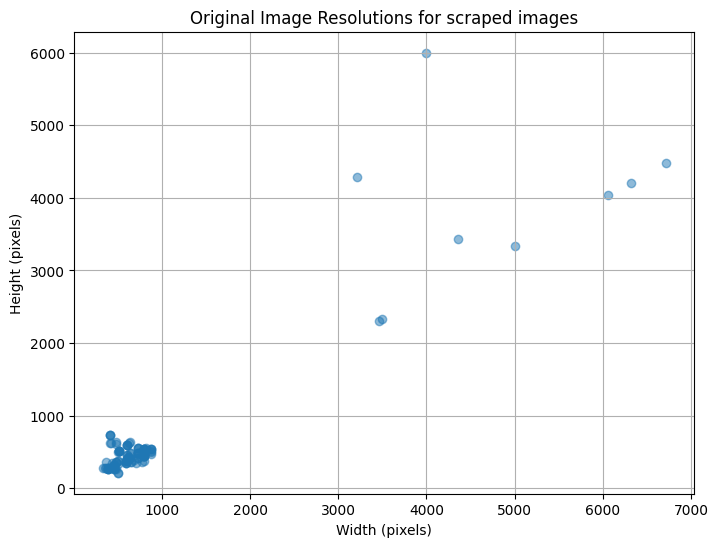

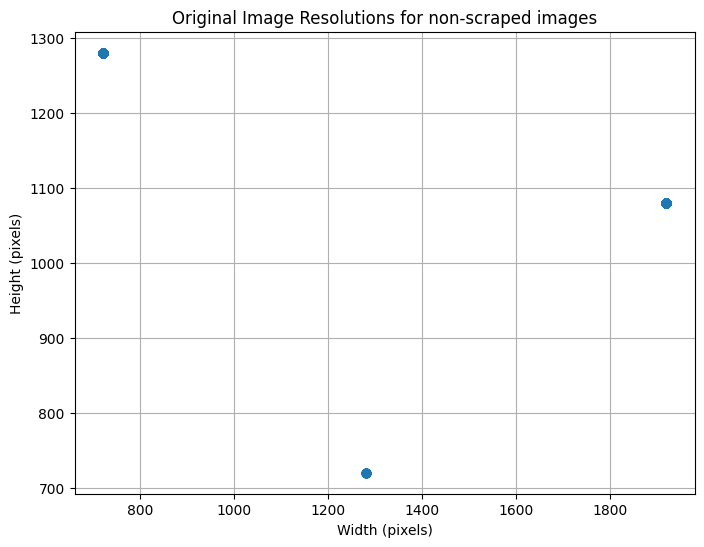

In [ ]:
# Display the image sizes before and after processing
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
# Read the filtered CSV as the resolution doesnt change after processing, and find classes where the 2nd column contains "google"
filtered_df2 = pd.read_csv(step1_path)
filtered_df2 = filtered_df2[filtered_df2.iloc[:, 1].str.contains("google", case=False, na=False)]
# Extract original resolutions from the 4th column
resolutions = filtered_df2.iloc[:, 3].dropna().tolist()
widths, heights = zip(*(map(int, res.split('x')) for res in resolutions if 'x' in res))
# Plot original resolutions as scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.title('Original Image Resolutions for scraped images')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.show()

# Read the filtered CSV as the resolution doesnt change after processing, and find classes where the 2nd column does not contain "google"
filtered_df2 = pd.read_csv(step1_path)
filtered_df2 = filtered_df2[~filtered_df2.iloc[:, 1].str.contains("google", case=False, na=False)]
# Extract original resolutions from the 4th column
resolutions = filtered_df2.iloc[:, 3].dropna().tolist()
widths, heights = zip(*(map(int, res.split('x')) for res in resolutions if 'x' in res))
# Plot original resolutions as scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.title('Original Image Resolutions for non-scraped images')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.show()


# Brightness and Bluriness

                       count  lap_var_mean  lap_var_std  brightness_mean  \
class_name                                                                 
avocado_firm_self       1439     59.253245    56.316153       110.605884   
avocado_breaking_self    814     63.606296    43.553820       109.568084   
avocado_ripe_self        772     60.724633    46.140519       108.415843   
banana_day1_self          50     51.917928    62.442801       128.677531   
banana_day2_self          50     17.588865    17.452228       127.599603   
banana_day3_self          50     50.805139    39.542031       127.980576   
banana_day4_self          49     35.044515    18.499170       131.153691   
banana_day5_self          49     54.764076    29.722959       127.890027   
banana_day6_self          48     49.450827    33.555011       125.752227   
banana_day7_self          47     53.732976    30.178905       124.559703   

                       brightness_std  
class_name                             
avocado

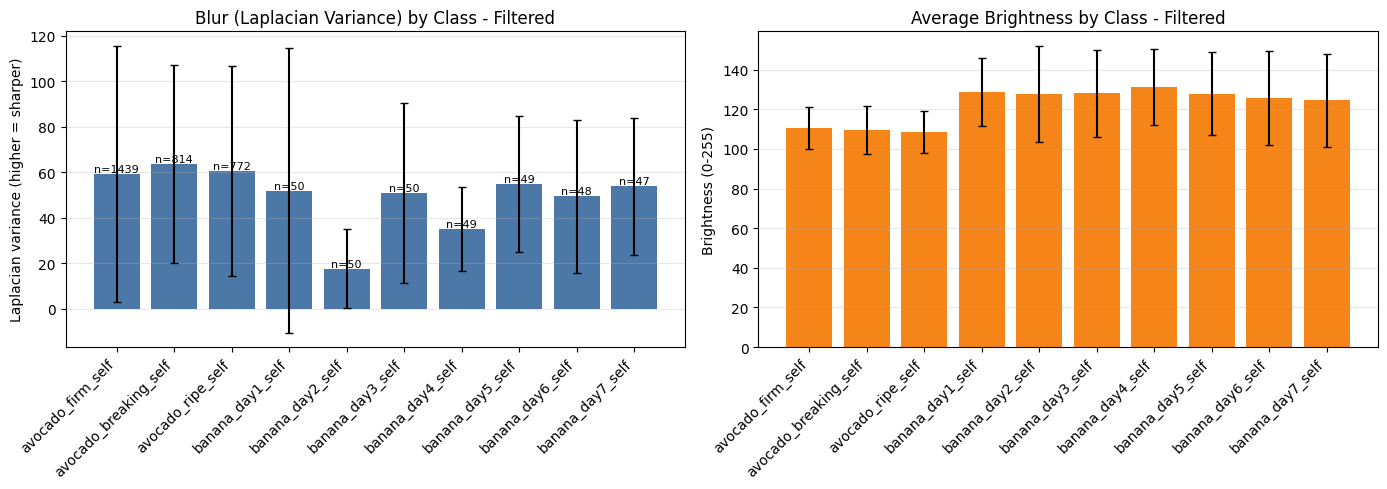

Processed 3368 images across 10 classes using 12 workers.
                       count  lap_var_mean  lap_var_std  brightness_mean  \
class_name                                                                 
alpukat_unripe_google     59    847.091118   819.545723       149.032543   
alpukat_ripe_google       57    857.646089   867.676126       153.688952   

                       brightness_std  
class_name                             
alpukat_unripe_google       41.050147  
alpukat_ripe_google         45.787059  


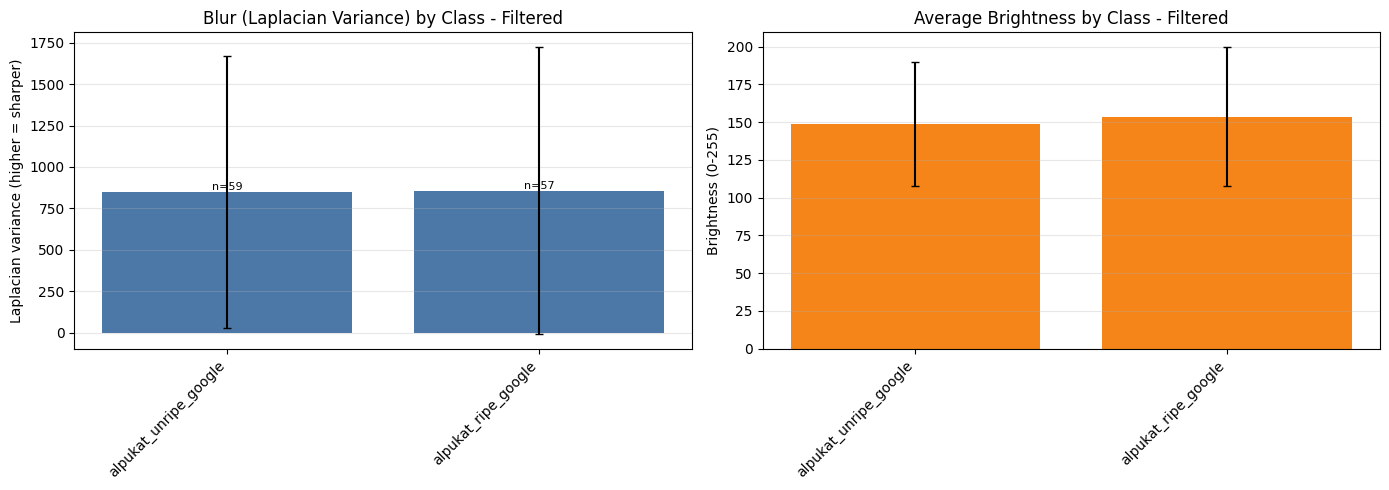

Processed 116 images across 2 classes using 12 workers.


In [ ]:
from concurrent.futures import ThreadPoolExecutor
from typing import Tuple, Optional
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_image_quality_by_class(
    df,
    class_column: Optional[str] = None,
    path_column: str = "file_path",
    max_workers: Optional[int] = None,
    dataset_name: str = "Dataset",
) -> Tuple[Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Compute Laplacian variance (focus/blur measure) and average brightness for each image,
    aggregate per class, and draw summary plots. Runs image processing in parallel.

    Returns:
      - per_image_df: DataFrame with columns [class_column, laplacian_variance, avg_brightness]
      - summary_df: Aggregated stats per class with mean/std and counts
    """
    if class_column is None:
        # Use existing global `class_col` variable
        class_column = class_col

    # Collect valid (path, class) pairs
    pairs = []
    for _, row in df.iterrows():
        p = row[path_column]
        c = row[class_column]
        if isinstance(p, str) and os.path.isfile(p):
            pairs.append((p, c))

    if not pairs:
        print("No valid image paths found.")
        return None, None

    def _worker(args):
        path, cls = args
        try:
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            if img is None:
                return None
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            lap_var = float(cv2.Laplacian(gray, cv2.CV_64F).var())
            brightness = float(gray.mean())
            return (cls, lap_var, brightness)
        except Exception:
            return None

    max_workers = max_workers or min(32, (os.cpu_count() or 4))
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        for r in ex.map(_worker, pairs):
            if r is not None:
                results.append(r)

    if not results:
        print("No images processed successfully.")
        return None, None

    per_image_df = pd.DataFrame(results, columns=[class_column, "laplacian_variance", "avg_brightness"])

    summary = (
        per_image_df.groupby(class_column)
        .agg(
            count=("laplacian_variance", "count"),
            lap_var_mean=("laplacian_variance", "mean"),
            lap_var_std=("laplacian_variance", "std"),
            brightness_mean=("avg_brightness", "mean"),
            brightness_std=("avg_brightness", "std"),
        )
        .sort_values("count", ascending=False)
    )
    print(summary)
    # Plot: blur metric and brightness with error bars
    classes = summary.index.tolist()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

    axes[0].bar(classes, summary["lap_var_mean"], yerr=summary["lap_var_std"], capsize=3, color="#4C78A8")
    axes[0].set_title(f"Blur (Laplacian Variance) by Class - {dataset_name}")
    axes[0].set_ylabel("Laplacian variance (higher = sharper)")
    axes[0].grid(axis="y", alpha=0.3)
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")
    # Annotate counts on top
    for i, (cls, row) in enumerate(summary.iterrows()):
        axes[0].text(i, row["lap_var_mean"], f"n={int(row['count'])}", ha="center", va="bottom", fontsize=8)

    axes[1].bar(classes, summary["brightness_mean"], yerr=summary["brightness_std"], capsize=3, color="#F58518")
    axes[1].set_title(f"Average Brightness by Class - {dataset_name}")
    axes[1].set_ylabel("Brightness (0-255)")
    axes[1].grid(axis="y", alpha=0.3)
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")

    plt.tight_layout()
    plt.show()

    print(f"Processed {len(per_image_df)} images across {summary.shape[0]} classes using {max_workers} workers.")
    return per_image_df, summary

filtered_df2 = pd.read_csv(step1_path)
filtered_df2 = filtered_df2[~filtered_df2.iloc[:, 1].str.contains("google", case=False, na=False)]

# Example usage on filtered and unfiltered datasets:
per_image_df_filtered, summary_filtered = compute_image_quality_by_class(
    filtered_df2, class_column=class_col, path_column="file_path", dataset_name="Filtered"
)

filtered_df2 = pd.read_csv(step1_path)
filtered_df2 = filtered_df2[filtered_df2.iloc[:, 1].str.contains("google", case=False, na=False)]

# Example usage on filtered and unfiltered datasets:
per_image_df_filtered, summary_filtered = compute_image_quality_by_class(
    filtered_df2, class_column=class_col, path_column="file_path", dataset_name="Filtered"
)

# Uncomment to run on unfiltered as well (heavier):
# per_image_df_unfiltered, summary_unfiltered = compute_image_quality_by_class(
#     unfiltered_df, class_column=class_col_unfiltered, path_column="file_path", dataset_name="Unfiltered"
# )

In [ ]:
%run createDerivation.py


all_df = pd.read_csv("./filtered_result.csv")
def keep_all(path): return True
def identity_map(path):
    with open(path, "rb") as f: return f.read()
default_variation_csv = create_dataset_variation(all_df, keep_all, identity_map, variation_tag="identity")
print(default_variation_csv)

def unsharp_mask_map(path: str, gamma=0) -> bytes:
    """
    Apply unsharp mask to the image at 'path' and return the processed image bytes.
    - alpha: weight of the original image
    - beta: weight of the blurred image (negative for sharpening)
    - gamma: scalar added to each sum
    """
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not read image at {path}")
    blurred = cv2.GaussianBlur(img, (5, 5), sigmaX=3, sigmaY=3)
    weight = 1.5
    sharpened = cv2.addWeighted(img, 1 + weight, blurred, -weight, gamma)
    _, buf = cv2.imencode('.jpg', sharpened)
    return buf.tobytes()
unsharp_variation_csv = create_dataset_variation(all_df, keep_all, unsharp_mask_map, variation_tag="unsharp")
print(unsharp_variation_csv)

# Build a YOLO-based preprocessing + filtering pipeline using create_dataset_variation

# Choose base dataset to (re)process
target_df = pd.read_csv(unsharp_variation_csv)

# Ensure required globals exist
assert 'MODEL_NAME' in globals(), "MODEL_NAME not defined (from earlier YOLO cell)."
assert 'FINAL_SIZE' in globals(), "FINAL_SIZE not defined (from earlier YOLO cell)."
assert 'TARGET_CLASSES' in globals(), "TARGET_CLASSES not defined (from earlier YOLO cell)."
assert 'create_dataset_variation' in globals(), "create_dataset_variation not available."

print(f"Loading YOLO model: {MODEL_NAME} ...")
try:
    _yolo_model = YOLO(MODEL_NAME)
except Exception as e:
    raise RuntimeError(f"Failed to load YOLO model '{MODEL_NAME}': {e}")

_target_classes = set(TARGET_CLASSES)

def _best_square_crop_from_results(image, results, names):
    img_h, img_w = image.shape[:2]
    best_detection = None
    highest_conf = -1.0

    for result in results:
        if result.boxes is None:
            continue
        for box in result.boxes:
            class_id = int(box.cls[0])
            class_name = names.get(class_id, str(class_id))
            if class_name not in _target_classes:
                continue
            conf = float(box.conf[0])
            if conf > highest_conf:
                highest_conf = conf
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().tolist()
                best_detection = (x1, y1, x2, y2)

    if best_detection is None:
        return None

    x1, y1, x2, y2 = best_detection
    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)
    dist_to_top = cy
    dist_to_bottom = img_h - cy
    dist_to_left = cx
    dist_to_right = img_w - cx
    half_size = int(min(dist_to_top, dist_to_bottom, dist_to_left, dist_to_right))
    if half_size <= 0:
        return None
    return (
        max(0, cx - half_size),
        max(0, cy - half_size),
        min(img_w, cx + half_size),
        min(img_h, cy + half_size),
    )

# Precompute crop regions for all valid images in base_df
print(f"Scanning {len(target_df)} images for target objects: {sorted(_target_classes)}")
_crop_index = {}
_skipped = 0
for i, row in target_df.iterrows():
    p = row["file_path"]
    if not isinstance(p, str) or not os.path.isfile(p):
        _skipped += 1
        continue
    img = cv2.imread(p)
    if img is None:
        _skipped += 1
        continue
    try:
        results = _yolo_model(img, verbose=False)
        crop_box = _best_square_crop_from_results(img, results, _yolo_model.names)
        if crop_box is not None:
            _crop_index[p] = crop_box
    except Exception:
        _skipped += 1

print(f"Found {len(_crop_index)} images with target detections. Skipped: {_skipped}")

def yolo_filter_fn(path: str) -> bool:
    return path in _crop_index

def yolo_crop_map_fn(path: str) -> bytes:
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not read image: {path}")
    x1, y1, x2, y2 = _crop_index.get(path, (0, 0, img.shape[1], img.shape[0]))
    cropped = img[y1:y2, x1:x2]
    if cropped.size == 0:
        cropped = img  # fallback to original if something went wrong
    resized = cv2.resize(cropped, FINAL_SIZE, interpolation=cv2.INTER_AREA)
    ok, buf = cv2.imencode(".png", resized)
    if not ok:
        raise RuntimeError("Failed to encode cropped image.")
    return buf.tobytes()

variation_tag = f"yolo_crop_{MODEL_NAME}_to_{FINAL_SIZE[0]}x{FINAL_SIZE[1]}"
filtered2_path = create_dataset_variation(target_df, yolo_filter_fn, yolo_crop_map_fn, variation_tag=variation_tag)
print("New variation CSV:", filtered2_path)
f = open("final_variation.txt", "w")
f.write(filtered2_path)
f.close()

Loading YOLO model: yolo11x-seg.pt ...
Scanning 3484 images for target objects: ['apple', 'avocado', 'banana']
Found 2962 images with target detections. Skipped: 0
Wrote 2975 rows to /home/fadhlan/Normal2/DeepLearningRepo/steps/variations/var_5118e532c6e15885/5118e532c6e15885.csv (variation 5118e532c6e15885)
New variation CSV: /home/fadhlan/Normal2/DeepLearningRepo/steps/variations/var_5118e532c6e15885/5118e532c6e15885.csv


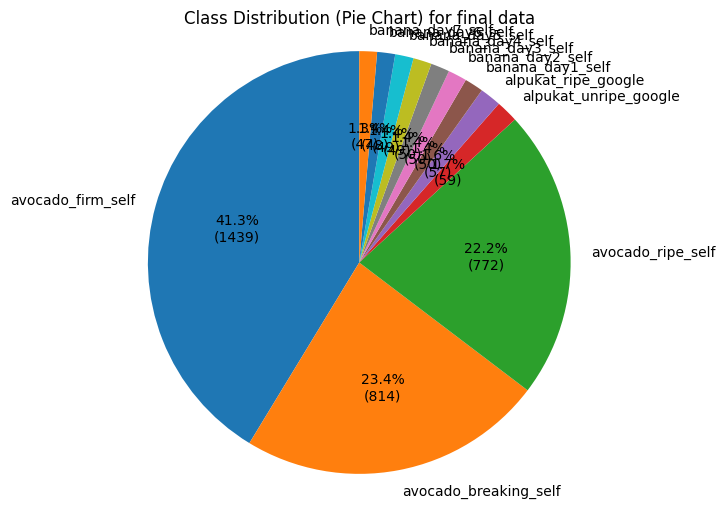

In [ ]:
class_col = 'class_name' if 'class_name' in all_df.columns else all_df.columns[-1]
final_df = pd.read_csv(filtered2_path)
# Count occurrences of each class
class_counts = all_df[class_col].value_counts()

# Pie chart of class distribution with numbers shown
def make_autopct(values):
    def my_autopct(pct):
        total = int(values.sum())
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({val})'
    return my_autopct

plt.figure(figsize=(6, 6))
class_counts.plot(
    kind='pie',
    autopct=make_autopct(class_counts),
    startangle=90,
    legend=False
)
plt.title('Class Distribution (Pie Chart) for final data')
plt.ylabel('')
plt.axis('equal')  # keep pie circular
plt.show()
